In [216]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Add working directory from google drive
FOLDERNAME = 'CS6220/HW7'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Specify the working directory
work_path = '/content/drive/My Drive/{}'.format(FOLDERNAME)

# Add to the system
import sys
sys.path.append(work_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [217]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [218]:
train_data = pd.read_csv(os.path.join(work_path, "titanic.train.csv"))
test_data = pd.read_csv(os.path.join(work_path, "titanic.test.csv"))

In [219]:
train_data.shape

(891, 14)

In [220]:
train_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,1,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.50,NaN,S,11,NaN,NaN
1,2,1,"Quick, Miss. Winifred Vera",female,8.0,1,1,26360,26.00,NaN,S,11,NaN,"Plymouth, Devon / Detroit, MI"
2,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.60,C2,S,8,NaN,"Isleworth, England"
3,1,0,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S,NaN,269.0,"Milwaukee, WI"
4,3,1,"Daly, Miss. Margaret Marcella ""Maggie""",female,30.0,0,0,382650,6.95,NaN,Q,15,NaN,"Co Athlone, Ireland New York, NY"


In [221]:
test_data.shape

(418, 13)

In [222]:
test_data.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,3,0,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN
1,1,3,0,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S,"Salo, Finland Astoria, OR"
2,2,3,0,"Alexander, Mr. William",male,26.0,0,0,3474,7.8875,NaN,S,"England Albion, NY"
3,3,1,1,"Schabert, Mrs. Paul (Emma Mock)",female,35.0,1,0,13236,57.7500,C28,C,"New York, NY"
4,4,1,0,"Rosenshine, Mr. George (""Mr George Thorne"")",male,46.0,0,0,PC 17585,79.2000,NaN,C,"New York, NY"


In [223]:
# remove the first column
test_data = test_data.iloc[:,1:]

In [224]:
test_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,0,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN
1,3,0,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S,"Salo, Finland Astoria, OR"
2,3,0,"Alexander, Mr. William",male,26.0,0,0,3474,7.8875,NaN,S,"England Albion, NY"
3,1,1,"Schabert, Mrs. Paul (Emma Mock)",female,35.0,1,0,13236,57.7500,C28,C,"New York, NY"
4,1,0,"Rosenshine, Mr. George (""Mr George Thorne"")",male,46.0,0,0,PC 17585,79.2000,NaN,C,"New York, NY"


## Feature Engineering

Explanations are in Assignment 7 - EDA.ipynb

In [225]:
def preprocess(data, categories=None):
    clean_data = pd.DataFrame()
    if not categories:
        categories = {}

    # Handle survived
    clean_data["survived"] = data["survived"]

    # Handle pclass (assume in test set the value is 1, 2, 3)
    if "pclass" not in categories.keys():
        categories["pclass"] = sorted(set(data[~data["pclass"].isna()]['pclass']))
    clean_data = pd.concat([
        clean_data,
        pd.get_dummies(
            pd.Categorical(data["pclass"], categories=categories["pclass"]),
            columns=["pclass"], drop_first=True, dummy_na=True
        )
    ], axis=1)
    clean_data.rename(columns={
        2.0: "pclass_2",
        3.0: "pclass_3",
        clean_data.columns[3]: "pclass_NaN"
    }, inplace=True)  # onehot for NaN

    # Handle sex (assume in test set the value in sex contains male)
    clean_data = pd.concat([
        clean_data,
        pd.get_dummies(data["sex"], columns=["sex"], drop_first=True)
    ], axis=1)
    clean_data.loc[clean_data["male"].isna(),"male"] = 1  # mode imputation

    # Handle age
    clean_data["age"] = data["age"].apply(lambda x: float(x))
    clean_data["missing_age"] = clean_data["age"].isnull()
    clean_data.loc[clean_data["missing_age"], "age"] = np.mean(clean_data["age"])  # mean imput
    clean_data["age>18"] = clean_data["age"] > 18
    clean_data["missing_age"] = clean_data["missing_age"].astype(int)
    clean_data["age>18"] = clean_data["age>18"].astype(int)
    if "age_mean" not in categories.keys():
        categories["age_mean"] = np.mean(data["age"])
    if "age_std" not in categories.keys():
        categories["age_std"] = np.std(data["age"])
    clean_data["age"] = (clean_data["age"] - categories["age_mean"]) / categories["age_std"]

    # # Handle sibsp
    converted_sibsp = data["sibsp"].apply(lambda x: str(x) if x < 4 else "4+")
    converted_sibsp = pd.DataFrame(converted_sibsp, columns=["sibsp"])
    if "sibsp" not in categories.keys():
        categories["sibsp"] = sorted(set(converted_sibsp['sibsp']))
    clean_data = pd.concat([
        clean_data,
        pd.get_dummies(
            pd.Categorical(converted_sibsp["sibsp"], categories=categories["sibsp"]),
            columns=["sibsp"], drop_first=True, dummy_na=True
        )
    ], axis=1)
    clean_data.rename(columns={
        "1": "sibsp_1",
        "2": "sibsp_2",
        "3": "sibsp_3",
        "4+": "sibsp_4+",
        clean_data.columns[-1]: "sibsp_NaN"
    }, inplace=True)  # onehot for NaN

    # Handle parch
    converted_parch = data["parch"].apply(lambda x: str(x) if x < 4 else "4+")
    converted_parch = pd.DataFrame(converted_parch, columns=["parch"])
    if "parch" not in categories.keys():
        categories["parch"] = sorted(set(converted_parch['parch']))
    clean_data = pd.concat([
        clean_data,
        pd.get_dummies(
            pd.Categorical(converted_parch["parch"], categories=categories["parch"]),
            columns=["parch"], drop_first=True, dummy_na=True
        )
    ], axis=1)
    clean_data.rename(columns={
        "1": "parch_1",
        "2": "parch_2",
        "3": "parch_3",
        "4+": "parch_4+",
        clean_data.columns[-1]: "parch_NaN"
    }, inplace=True)  # onehot for NaN

    # Handle fare
    clean_data["fare"] = data["fare"].apply(lambda x: float(x))
    clean_data["fare"].fillna(np.nanmedian(clean_data["fare"]), inplace=True) # median imput
    if "fare_min" not in categories.keys():
        categories["fare_min"] = np.min(data["fare"])
    if "fare_max" not in categories.keys():
        categories["fare_max"] = np.max(data["fare"])
    clean_data["fare"] = (clean_data["fare"] - categories["fare_min"]) / (categories["fare_max"] - categories["fare_min"])

    # Handle cabin
    cabin_not_alone = sorted(set(list(data["cabin"].value_counts()[data["cabin"].value_counts() > 1].index)))
    if "cabin_not_alone" not in categories.keys():
        categories["cabin_not_alone"] = sorted(set(cabin_not_alone))
    clean_data["cabin_not_alone"] = data["cabin"].isin(categories["cabin_not_alone"]).astype(int)
    clean_data["cabin_NaN"] = data["cabin"].isna().astype(int)

    # Handle embarked (assume in test set the value is S, C, Q)
    if "embarked" not in categories.keys():
        categories["embarked"] = set(data[~data["embarked"].isna()]["embarked"])
    clean_data = pd.concat([
        clean_data,
        pd.get_dummies(
            pd.Categorical(data["embarked"], categories=categories["embarked"]),
            columns=["embarked"], drop_first=True, dummy_na=True
        )
    ], axis=1)
    clean_data.rename(columns={
        "C": "embarked_c",
        "S": "embarked_s",
        clean_data.columns[-1]: "embarked_NaN"
    }, inplace=True)  # onehot for NaN

    # Filter for survived is not null
    clean_data = clean_data[~clean_data["survived"].isna()]

    clean_data.reset_index(drop=True, inplace=True)
    X = clean_data.drop(columns=["survived"])
    y = np.expand_dims(clean_data["survived"], axis=1)

    return X.values, y, categories

In [226]:
X_train, y_train, categories = preprocess(train_data)
X_test, y_test, _ = preprocess(test_data, categories)

## Logistic Regression

In [227]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gradsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def logreg(W, x, b):
    return sigmoid( (W @ x.T).T + b)

def costfxn(y, W, x, b):
  '''
  Calculate the overall binary cross-entropy cost function

  Args:
    * y: N x m matrix
    * W: m x d matrix
    * x: N x d matrix of data
    * b: m offsite vector

  Returns:
    * A scalar cost value (summed over all data in the batch)
  '''
  # YOUR CODE HERE
  yhat = logreg(W, x, b)
  return -np.sum( y * np.log(yhat) + ( 1 - y ) * np.log(1 - yhat) )


def gradW(y, W, x, b):
  '''
  Calculate the gradient w/r/t W

  Args:
    * y: N x m matrix
    * W: m x d matrix
    * x: N x d matrix of data
    * b: m offsite vector

  Returns:
    * gradient of size m x d
  '''
  # YOUR CODE HERE
  yhat = logreg(W, x, b)
  return (np.expand_dims(yhat - y, 2) * np.expand_dims(x, 1)).sum(axis=0)

def gradb(y, W, x, b):
  '''
  Calculate the gradient w/r/t b

  Args:
    * y: N x m matrix
    * W: m x d matrix
    * x: N x d matrix of data
    * b: m offset vector

  Returns:
    * gradient of size N x m
  '''
  # YOUR CODE HERE
  yhat = logreg(W, x, b)
  return (yhat - y).sum(axis=0)

In [233]:
# Hyperparameters
learning_rate = 0.001
epochs = 2000

# Initialize parameters
W = np.random.randn(1, X_train.shape[1])
b = np.random.randn(1)

# Training
costs = []
for epoch in range(epochs):
    # Forward pass
    cost = costfxn(y_train, W, X_train, b)
    costs.append(cost)

    # Backward pass
    dW = gradW(y_train, W, X_train, b)
    db = gradb(y_train, W, X_train, b)

    # Step
    W -= learning_rate * dW
    b -= learning_rate * db

    if epoch % 200 == 0:
        cost = costfxn(y_train, W, X_train, b)
        y_test_hat = logreg(W, X_test, b)
        y_test_pred = y_test_hat > 0.5
        y_train_hat = logreg(W, X_train, b)
        y_train_pred = y_train_hat > 0.5
        train_accuracy = np.mean(y_train_pred.astype(int) == y_train)
        test_accuracy = np.mean(y_test_pred.astype(int) == y_test)
        print(f"Epoch {epoch}, Cost: {round(cost, 4)}, Train_acc: {round(train_accuracy, 4)}, Test_acc: {round(test_accuracy, 4)}")

Epoch 0, Cost: 1014.6612, Train_acc: 0.6049, Test_acc: 0.6603
Epoch 200, Cost: 415.8141, Train_acc: 0.7744, Test_acc: 0.8014
Epoch 400, Cost: 407.6669, Train_acc: 0.7912, Test_acc: 0.8062
Epoch 600, Cost: 404.5968, Train_acc: 0.7924, Test_acc: 0.8014
Epoch 800, Cost: 403.238, Train_acc: 0.7957, Test_acc: 0.799
Epoch 1000, Cost: 402.5741, Train_acc: 0.7957, Test_acc: 0.799
Epoch 1200, Cost: 402.2234, Train_acc: 0.7969, Test_acc: 0.8014
Epoch 1400, Cost: 402.0247, Train_acc: 0.7957, Test_acc: 0.8014
Epoch 1600, Cost: 401.9051, Train_acc: 0.7957, Test_acc: 0.8014
Epoch 1800, Cost: 401.8288, Train_acc: 0.798, Test_acc: 0.8014


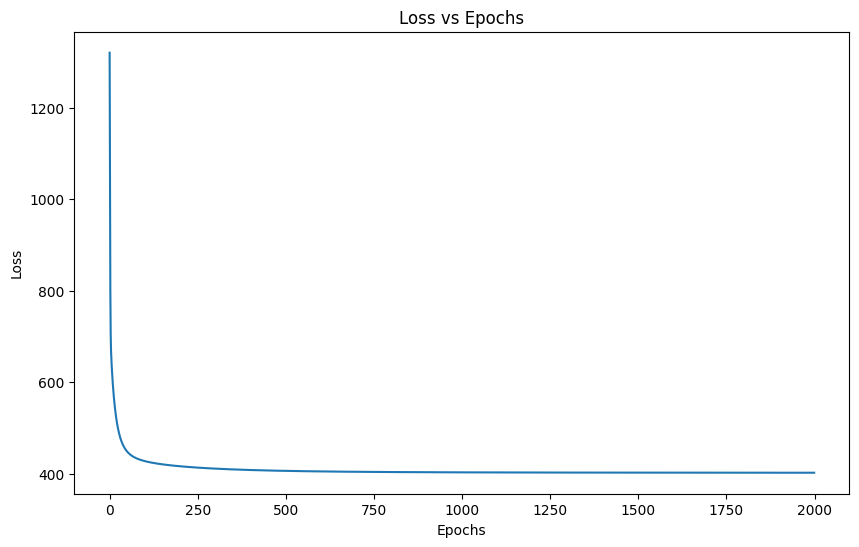

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax = sns.lineplot(np.array(costs))
ax.set_title('Loss vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

In [422]:
threshold = 0.5
y_test_pred = logreg(W, X_test, b) > threshold
y_train_pred = logreg(W, X_train, b) > threshold
test_accuracy = np.mean(y_test_pred.astype(int) == y_test)
train_accuracy = np.mean(y_train_pred.astype(int) == y_train)
print(f"Learning rate: {learning_rate}, Train_acc: {round(train_accuracy, 4)}, Test_acc: {round(test_accuracy, 4)}")

Learning rate: 0.001, Train_acc: 0.798, Test_acc: 0.8014


### Neural Network

Below is the architecture that we're using. All linear layers have 128 hidden dimension.

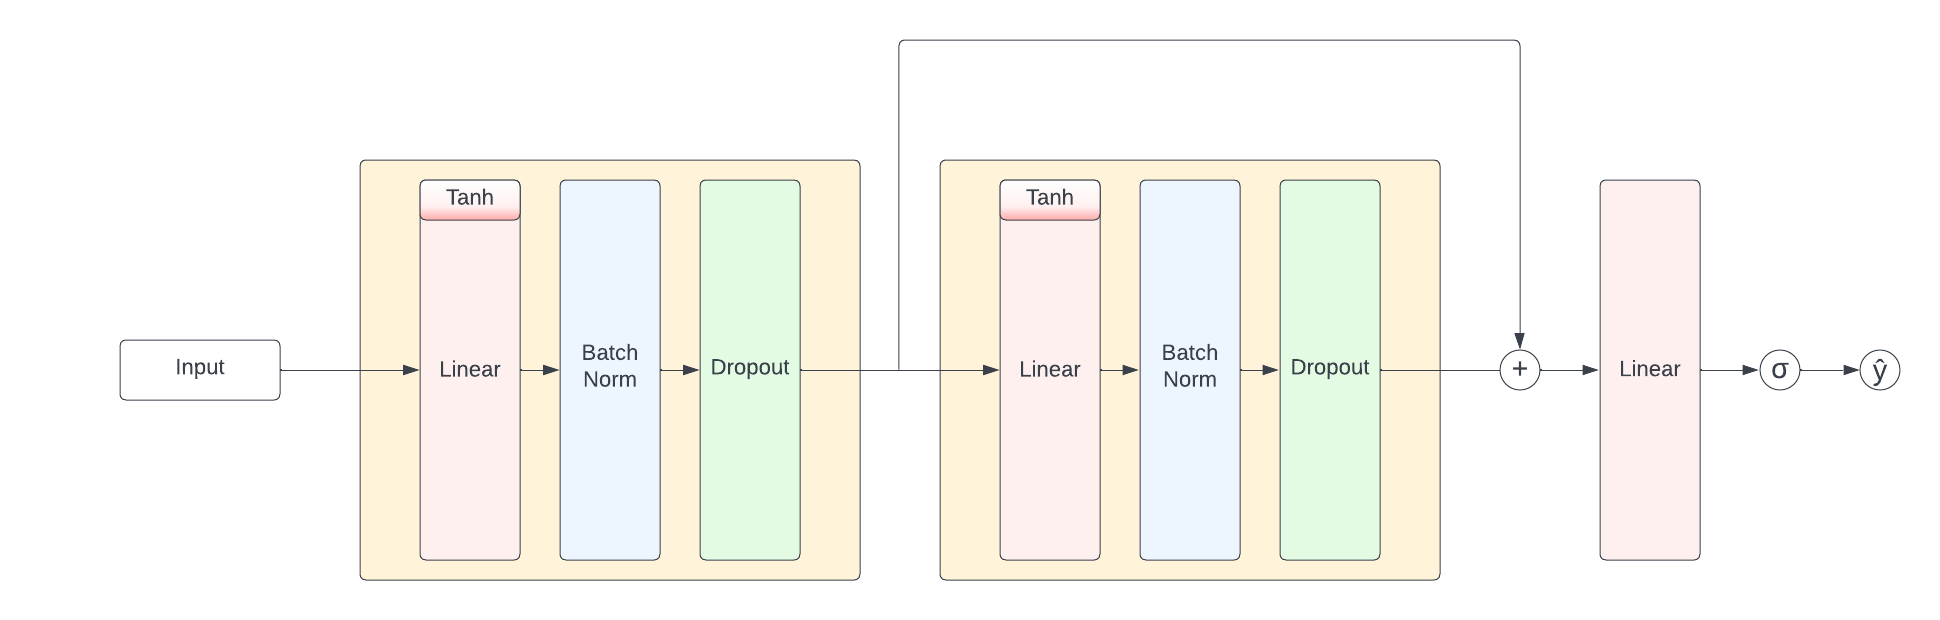

In [249]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm

In [416]:
class LogisticRegressionNet(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionNet, self).__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(128, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(self.bn1(F.tanh(x)))
        x_copy = x
        x = self.linear2(x)
        x = self.dropout2(self.bn2(F.tanh(x))) + x_copy
        x = self.output(x)
        return x

In [417]:
train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_data = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())

In [418]:
batch_size = 64
num_epochs = 500

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

model = LogisticRegressionNet(X_train.shape[1])

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

train_losses_history = []
train_acc_history = []
test_losses_history = []
test_acc_history = []

for epoch in tqdm(range(num_epochs), desc="Training Progress"):

    model.train()
    train_loss = 0.0
    train_corrects = 0
    total_train_samples = 0
    N = len(train_loader)

    for inputs, labels in train_loader:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

        # calculate statistics
        train_loss += loss.item() * inputs.size(0)
        preds = outputs > 0
        train_corrects += torch.sum(preds == labels)
        total_train_samples += inputs.size(0)


    avg_train_loss = train_loss / total_train_samples
    train_accuracy = train_corrects.double() / total_train_samples
    train_losses_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)

    # put model to evaluation mode
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    total_test_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # calculate statistics
            test_loss += loss.item() * inputs.size(0)
            preds = outputs > 0
            test_corrects += torch.sum(preds == labels)
            total_test_samples += inputs.size(0)

    # calculate both average validation loss and validation accuracy
    avg_test_loss = test_loss / total_test_samples
    test_accuracy = test_corrects.double() / total_test_samples
    test_losses_history.append(avg_test_loss)
    test_acc_history.append(test_accuracy)

train_acc_history = np.array(train_acc_history)
test_acc_history = np.array(test_acc_history)
train_losses_history = np.array(train_losses_history)
test_losses_history = np.array(test_losses_history)

Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

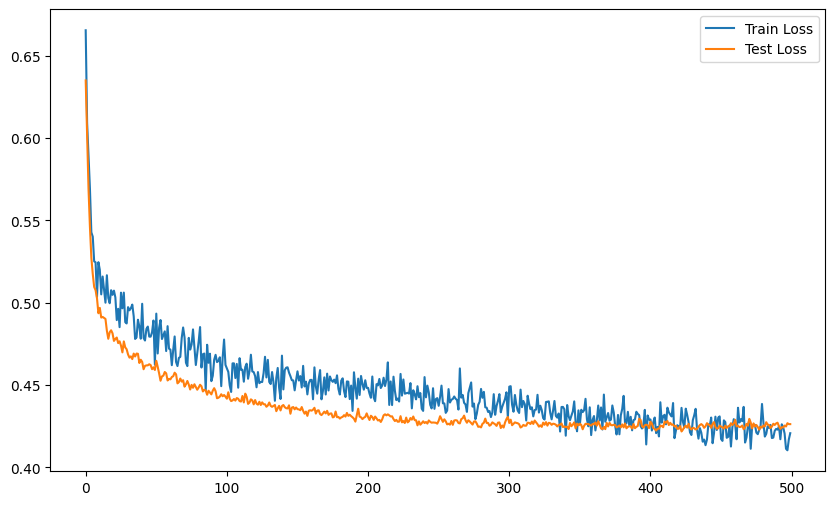

In [419]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax = sns.lineplot(x=range(num_epochs), y=train_losses_history, label='Train Loss')
ax = sns.lineplot(x=range(num_epochs), y=test_losses_history, label='Test Loss')

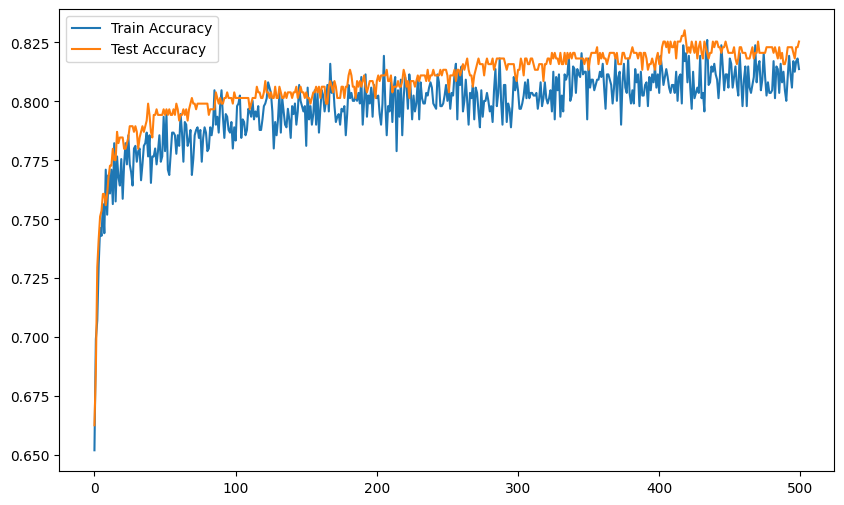

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax = sns.lineplot(x=range(num_epochs), y=train_acc_history, label='Train Accuracy')
ax = sns.lineplot(x=range(num_epochs), y=test_acc_history, label='Test Accuracy')

In [423]:
print(f"Learning rate: 0.00005, Train Accuracy: {round(train_acc_history[-1], 3)}, Test Accuracy: {round(test_acc_history[-1], 3)}")

Learning rate: 0.00005, Train Accuracy: 0.814, Test Accuracy: 0.825


Compared to the logistic regression test accuracy: 0.8014, the neural network model gave us improvement.